Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367

# Autoencoders for Rare Event Prediction

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)
os.getcwd()

# Libraries

In [ ]:
import numpy as np
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import constraints
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.constraints import Constraint
from tensorflow.python.framework import tensor_shape

from numpy.random import seed
seed(123)

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy

# User-defined library
import utilities.datapreprocessing as dp
import utilities.reconstructionperformance as rp
import utilities.simpleplots as sp

# Illustration with Arbitrary Data

In [ ]:
# Select an arbitrary data dimension for testing.
n_dim = 5

# Generate a positive definite symmetric matrix to be 
# used as covariance to generate a random data.
cov = datasets.make_spd_matrix(n_dim, 
                               random_state=None)

# Generate a vector of mean for generating the random data.
mu = np.random.normal(loc=0, 
                      scale=0.1, 
                      size=n_dim)

# Generate the random data, X.
n = 1000
X = np.random.multivariate_normal(mean=mu, 
                                  cov=cov, 
                                  size=n)

# Well-posed Autoencoder

## Orthogonal Weights

In [ ]:
# Orthogonal weights constraint custom function.
class OrthogonalWeights (Constraint):
    def __init__(self, 
                 weightage = 1.0, 
                 axis = 0):
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, 
                              w):
        if(self.axis==1):
            w = K.transpose(w)
      
        wTwminusI = K.dot(K.transpose(w), w) - tf.eye(
            tf.shape(w, out_type=tf.float32)[1])
        
        return self.weightage * tf.math.sqrt(
            tf.math.reduce_sum(tf.math.square(wTwminusI)))

    def __call__(self, w):
        return self.weights_orthogonality(w)

## Independent Features

In [ ]:
# Orthogonal feature map or uncorrelated features require custom function.
class SparseCovariance (Constraint):

    def __init__(self, weightage=1.0):
        self.weightage = weightage

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.size <= 1):
            return 0.0
        else:
            # Sum of square of off-diagonal
            # covariance terms
            output = K.sum(K.square(
                self.covariance - 
                tf.math.multiply(self.covariance, 
                                 tf.eye(self.size))))
            return output

    def __call__(self, x):
        self.size = x.shape[1]
        x_centered = K.transpose(tf.math.subtract(
            x, K.mean(x, axis=0, keepdims=True)))

        self.covariance = K.dot(x_centered, K.transpose(x_centered)) / \
            tf.cast(x_centered.get_shape()[0], tf.float32)
            
        return self.weightage * self.uncorrelated_feature(x)

## Autoencoder

In [ ]:
nb_epoch = 100
batch_size = 16
input_dim = X.shape[1]
encoding_dim = 4
learning_rate = 1e-3

encoder = Dense(units=encoding_dim, 
                activation="relu", 
                input_shape=(input_dim,), 
                use_bias = True, 
                kernel_regularizer=OrthogonalWeights(
                    weightage=1., 
                    axis=0), 
                kernel_constraint=UnitNorm(axis=0),
                activity_regularizer=SparseCovariance(weightage=1.),
                name='encoder') 

decoder = Dense(units=input_dim, 
                activation="linear", 
                use_bias = True, 
                kernel_constraint=UnitNorm(axis=1),
                name='decoder') 

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='sgd')
autoencoder.summary()

autoencoder.fit(X, X,
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 4)                 24        
_________________________________________________________________
decoder (Dense)              (None, 5)                 25        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [ ]:
w_encoder = np.round(autoencoder.get_layer('encoder').get_weights()[0], 3)
w_decoder = np.round(autoencoder.get_layer('decoder').get_weights()[0], 3)
print('Encoder weights\n', w_encoder.T)
print('Decoder weights\n', w_decoder)

Encoder weights
 [[ 0.338  0.349  0.682  0.315 -0.447]
 [ 0.61   0.444 -0.606  0.245  0.065]
 [-0.346 -0.213 -0.384  0.475 -0.679]
 [-0.078 -0.208  0.145  0.779  0.567]]
Decoder weights
 [[ 0.322  0.384  0.659  0.219 -0.516]
 [ 0.279  0.484 -0.723  0.347  0.213]
 [-0.852  0.449  0.221 -0.118 -0.101]
 [-0.254 -0.421 -0.536  0.1    0.679]]


In [ ]:
b_encoder = np.round(np.transpose(autoencoder.get_layer('encoder').get_weights()[1]), 3)
b_decoder = np.round(np.transpose(autoencoder.get_layer('decoder').get_weights()[0]), 3)
print('Encoder bias\n', b_encoder)
print('Decoder bias\n', b_decoder)

Encoder bias
 [ 2.755 -0.448 -1.135 -0.691]
Decoder bias
 [[ 0.322  0.279 -0.852 -0.254]
 [ 0.384  0.484  0.449 -0.421]
 [ 0.659 -0.723  0.221 -0.536]
 [ 0.219  0.347 -0.118  0.1  ]
 [-0.516  0.213 -0.101  0.679]]


In [ ]:
w_encoder = autoencoder.get_layer('encoder').get_weights()[0]
print('Encoder weights dot product\n', 
      np.round(np.dot(w_encoder.T, w_encoder), 2))

w_decoder = autoencoder.get_layer('decoder').get_weights()[0]
print('Decoder weights dot product\n', 
      np.round(np.dot(w_decoder, w_decoder.T), 2))

Encoder weights dot product
 [[ 1.   -0.    0.   -0.01]
 [-0.    1.   -0.    0.  ]
 [ 0.   -0.    1.    0.  ]
 [-0.01  0.    0.    1.  ]]
Decoder weights dot product
 [[ 1.   -0.23  0.07 -0.93]
 [-0.23  1.   -0.24  0.29]
 [ 0.07 -0.24  1.   -0.17]
 [-0.93  0.29 -0.17  1.  ]]


In [ ]:
print('Encoder weights norm, \n', 
      np.round(np.sum(w_encoder ** 2, 
                      axis = 0), 
               2))
print('Decoder weights norm, \n', 
      np.round(np.sum(w_decoder ** 2, 
                      axis = 1), 
               2))

Encoder weights norm, 
 [1. 1. 1. 1.]
Decoder weights norm, 
 [1. 1. 1. 1.]


In [ ]:
encoder_model = Model(inputs=autoencoder.inputs, 
                      outputs=autoencoder.get_layer('encoder').output)
encoded_features = np.array(encoder_model.predict(X))
print('Encoded feature covariance\n', 
      np.round(np.cov(encoded_features.T), 2))

Encoded feature covariance
 [[ 4.5  -0.01 -0.   -0.02]
 [-0.01  0.03  0.    0.  ]
 [-0.    0.    0.   -0.  ]
 [-0.02  0.   -0.    0.01]]


In [ ]:
autoencoder.predict(X)

array([[ 0.46057808,  0.4906274 ,  1.0470139 ,  0.01820737, -1.0199108 ],
       [ 0.6191907 ,  0.67983806,  1.3717388 ,  0.1263017 , -1.2741475 ],
       [-0.5129963 , -0.6707599 , -0.9461683 , -0.6452826 ,  0.54061127],
       ...,
       [ 0.298833  ,  0.2976799 ,  0.715876  , -0.09202182, -0.7606528 ],
       [ 0.16705072,  0.14047539,  0.44608033, -0.18183124, -0.5494219 ],
       [ 0.1294533 ,  0.15876698, -0.17043126, -0.14174598, -0.21402812]],
      dtype=float32)

In [ ]:
X

array([[ 0.53703398, -0.19960221,  1.41282984,  0.0881038 , -1.02760805],
       [ 0.91229578,  0.73260919,  1.84492577,  0.29952297, -0.31057603],
       [-0.19275857, -1.19144588, -1.47906016, -0.66162669, -0.52711991],
       ...,
       [ 0.62835363,  0.25897206,  1.11338536, -0.3521594 , -0.24359925],
       [ 0.6996035 , -0.38217161,  1.16282927, -0.97146717, -0.13527475],
       [ 0.74758764, -0.20453699, -0.4972625 ,  0.84763569, -0.14135847]])

# Rare Event Detection

## Data preparation 

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [ ]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

# Hot encoding
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df = df.drop(['Grade&Bwt', 'EventPress'], 
             axis=1)

df = pd.concat([df, hotencoding1, hotencoding2], 
               axis=1)

# Rename response column name for ease of understanding
df = df.rename(columns={'SheetBreak': 'y'}) 

# Sort by time.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

# Drop the time column.
df = df.drop(['DateTime'], axis=1)

### Split the data and scale

In [ ]:
DATA_SPLIT_PCT = 0.2
SEED = 123
df_train, df_test = train_test_split(df, 
                                     test_size=DATA_SPLIT_PCT, 
                                     random_state=SEED)
df_train, df_valid = train_test_split(df_train, 
                                      test_size=DATA_SPLIT_PCT, 
                                      random_state=SEED)

df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [ ]:
scaler = StandardScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)

df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'],
                                                     axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], 
                                                   axis = 1))

## Undercomplete Autoencoder

In [ ]:
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 

encoder = Dense(units=32, 
                activation="relu", 
                input_shape=(input_dim,), 
                use_bias = True, 
                kernel_regularizer=
                  OrthogonalWeights(
                    weightage=1., 
                    axis=0), 
                kernel_constraint=
                  UnitNorm(axis=0),
                activity_regularizer=
                  SparseCovariance(weightage=1.),
                name='encoder') 

decoder = Dense(units=input_dim, 
                activation="linear", 
                use_bias = True, 
                kernel_constraint=
                  UnitNorm(axis=1),
                name='decoder') 

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

history = autoencoder.fit(x=df_train_0_x_rescaled, 
                          y=df_train_0_x_rescaled,
                          batch_size=128,
                          epochs=100,
                          validation_data=(df_valid_0_x_rescaled, 
                                           df_valid_0_x_rescaled),
                          verbose=0).history

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 32)                2240      
_________________________________________________________________
decoder (Dense)              (None, 69)                2277      
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Weights on encoder and decoder
w_encoder = np.round(np.transpose(autoencoder.get_layer('encoder').get_weights()[0]), 3)
w_decoder = np.round(autoencoder.get_layer('decoder').get_weights()[1], 3)
print('Encoder weights\n', w_encoder)
print('Decoder weights\n', np.transpose(w_decoder))

Encoder weights
 [[-0.049 -0.025  0.047 ...  0.024 -0.236  0.23 ]
 [-0.055  0.01   0.088 ...  0.273  0.192  0.167]
 [ 0.238 -0.084  0.259 ...  0.04   0.223 -0.146]
 ...
 [-0.013  0.226 -0.111 ...  0.005  0.009 -0.068]
 [-0.223  0.062 -0.021 ... -0.294  0.108  0.092]
 [-0.141  0.053  0.064 ... -0.098  0.173  0.002]]
Decoder weights
 [ 0.226 -0.269  0.108  0.201  0.063  0.395  0.208 -0.376  1.061  0.644
 -0.936 -1.096  0.457  1.367 -0.176 -1.336  0.441  0.348  0.045 -0.12
  0.356  0.073  0.32  -0.562 -1.278 -0.436 -0.676  0.048  0.035 -0.093
 -1.34  -0.122  0.316 -0.744  0.37  -0.521  0.905  0.38  -0.755  0.092
  0.208  1.097 -0.121  1.313  0.39   0.158  0.129  0.119 -0.062 -1.31
 -0.056  0.531 -0.072 -0.12   0.345  0.094 -1.007 -1.339 -0.151  0.582
  0.28   0.254  0.384 -0.06   0.534 -0.264  0.478  0.    -0.   ]


In [ ]:
# Near orthogonal encoding weights
w_encoder = autoencoder.get_layer('encoder').get_weights()[0]
print('Encoder weights dot product\n', 
      np.round(np.dot(w_encoder.T, w_encoder), 2))

Encoder weights dot product
 [[ 1.  0.  0. ... -0.  0.  0.]
 [ 0.  1. -0. ...  0.  0.  0.]
 [ 0. -0.  1. ...  0. -0.  0.]
 ...
 [-0.  0.  0. ...  1. -0.  0.]
 [ 0.  0. -0. ... -0.  1. -0.]
 [ 0.  0.  0. ...  0. -0.  1.]]


In [ ]:
# Encoding weights have unit norm 
w_encoder = np.round(autoencoder.get_layer('encoder').get_weights()[0], 2).T 
print('Encoder weights norm, \n', 
      np.round(np.sum(w_encoder ** 2, axis = 1), 1))

Encoder weights norm, 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Nearly uncorrelated encoded features
encoder_model = Model(inputs=autoencoder.inputs, 
                      outputs=autoencoder.get_layer('encoder').output)
encoded_features = pd.DataFrame(encoder_model.predict(df_train_0_x_rescaled))

print('Encoded feature correlations\n', 
      np.round(encoded_features.corr(), 2))

Encoded feature correlations
       0     1     2     3     4     5   ...    26    27    28    29    30    31
0   1.00 -0.07  0.02 -0.11  0.24  0.05  ...  0.12 -0.04  0.07 -0.08 -0.13  0.06
1  -0.07  1.00  0.00  0.05 -0.08 -0.01  ... -0.15  0.02 -0.07 -0.05 -0.11 -0.00
2   0.02  0.00  1.00  0.01  0.12  0.07  ...  0.19 -0.17 -0.09 -0.04  0.12  0.01
3  -0.11  0.05  0.01  1.00 -0.14  0.02  ... -0.01 -0.03 -0.10  0.16  0.02 -0.05
4   0.24 -0.08  0.12 -0.14  1.00 -0.06  ...  0.36 -0.07  0.07 -0.01  0.05  0.04
5   0.05 -0.01  0.07  0.02 -0.06  1.00  ... -0.04 -0.02 -0.09 -0.02 -0.01 -0.03
6  -0.04 -0.08 -0.02 -0.03 -0.07  0.00  ... -0.04 -0.01 -0.00 -0.09 -0.03 -0.02
7  -0.05  0.09  0.03  0.05  0.04  0.04  ... -0.14 -0.01 -0.09 -0.05 -0.02 -0.03
8  -0.12 -0.02 -0.17 -0.05 -0.19 -0.01  ... -0.14  0.04 -0.14  0.08  0.02 -0.08
9   0.01 -0.04 -0.05 -0.08  0.12 -0.04  ...  0.02 -0.03  0.13 -0.12 -0.03  0.01
10 -0.00 -0.01  0.14  0.03 -0.13  0.04  ...  0.05 -0.07 -0.07  0.01  0.05 -0.02
11  0.01 -

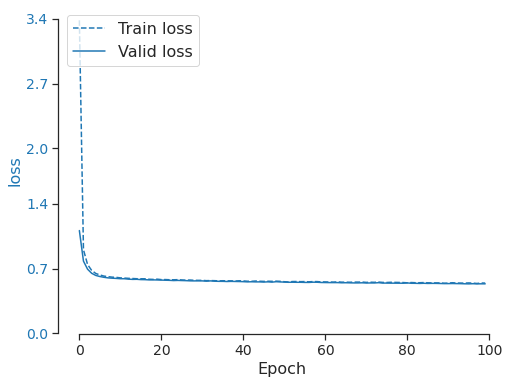

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('dense-autoencoder-pca-props-loss.pdf', bbox_inches='tight')

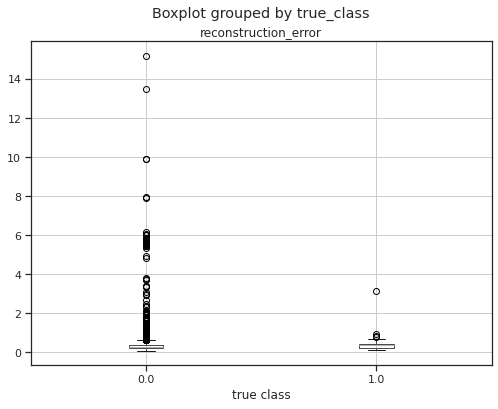

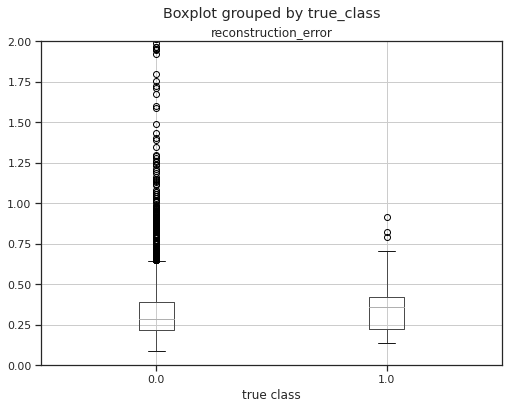

In [ ]:
error_vs_class_valid = rp.reconstructionerror_vs_class(model=autoencoder, 
                                                       sample=df_valid_x_rescaled, 
                                                       y=df_valid['y'])
plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid)
fig.savefig('dense-autoencoder-pca-props-master-boxplot.pdf', bbox_inches='tight')
plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid, ylim=[0., 2])
fig.savefig('dense-autoencoder-pca-props-snapshot-boxplot.pdf', bbox_inches='tight')

In [ ]:
errors_valid0 = rp.class_errors(error_vs_class=error_vs_class_valid, 
                                label=0)
errors_valid1 = rp.class_errors(error_vs_class=error_vs_class_valid, 
                                label=1)
rp.robust_stat_difference(z1=errors_valid0, 
                          z2=errors_valid1)

3.4644269751771124

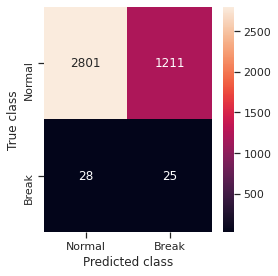

In [ ]:
error_vs_class_test = rp.reconstructionerror_vs_class(model=autoencoder, 
                                                      sample=df_test_x_rescaled, 
                                                      y=df_test['y'])
conf_matrix, fig = rp.model_confusion_matrix(error_vs_class=error_vs_class_test, 
                            threshold=errors_valid1.quantile(0.50))
fig.savefig('dense-autoencoder-pca-props-conf-matrix.pdf', 
            bbox_inches='tight')

## Sparse Autoencoder

In [ ]:
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 

encoder = Dense(units=input_dim, 
                activation="relu", 
                input_shape=(input_dim,), 
                use_bias = True, 
                kernel_constraint=
                  UnitNorm(axis=0),
                activity_regularizer=
                  tf.keras.regularizers.L1(l1=0.01),
                name='encoder') 

decoder = Dense(units=input_dim, 
                activation="linear", 
                use_bias = True, 
                kernel_constraint=
                  UnitNorm(axis=1),
                name='decoder') 

sparse_autoencoder = Sequential()
sparse_autoencoder.add(encoder)
sparse_autoencoder.add(decoder)

sparse_autoencoder.summary()
sparse_autoencoder.compile(metrics=['accuracy'],
                           loss='mean_squared_error',
                           optimizer='adam')

history = sparse_autoencoder.fit(x=df_train_0_x_rescaled, 
                                 y=df_train_0_x_rescaled,
                                 batch_size=128,
                                 epochs=100,
                                 validation_data=(df_valid_0_x_rescaled, 
                                     df_valid_0_x_rescaled),
                                 verbose=0).history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, 69)                4830      
_________________________________________________________________
decoder (Dense)              (None, 69)                4830      
Total params: 9,660
Trainable params: 9,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Weights on encoder
w_encoder = np.round(np.transpose(autoencoder.get_layer('encoder').get_weights()[0]), 3)
print('Encoder weights\n', w_encoder)

Encoder weights
 [[-0.049 -0.025  0.047 ...  0.024 -0.236  0.23 ]
 [-0.055  0.01   0.088 ...  0.273  0.192  0.167]
 [ 0.238 -0.084  0.259 ...  0.04   0.223 -0.146]
 ...
 [-0.013  0.226 -0.111 ...  0.005  0.009 -0.068]
 [-0.223  0.062 -0.021 ... -0.294  0.108  0.092]
 [-0.141  0.053  0.064 ... -0.098  0.173  0.002]]


In [ ]:
# Sparse encodings
encoder_model = Model(inputs=sparse_autoencoder.inputs, 
                      outputs=sparse_autoencoder.get_layer('encoder').output)
encoded_features = pd.DataFrame(encoder_model.predict(df_train_0_x_rescaled))

In [ ]:
encoded_features.round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,0.398,0.135,0.0,0.000,1.435,0.000,0.000,0.0,0.000,0.384,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,2.293,0.000,0.0,0.000,0.000,3.328,0.000,0.171,0.000,0.165,0.000,0.287,0.000,0.000,0.100,0.000,0.000,0.000,0.0,0.0,0.000,0.074,0.478,0.000,1.883,0.000,0.0,0.000,0.00,0.000,0.000,1.198,0.00,0.000,0.0,0.159,0.000,1.316,0.143,0.000,0.00
1,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.444,0.374,0.000,0.000,0.000,1.128,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,2.821,0.000,0.0,0.000,0.000,0.000,0.646,0.321,0.000,0.000,0.000,2.933,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.039,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.914,0.000,0.00,0.000,0.0,0.000,0.000,0.000,0.649,0.000,0.00
2,0.000,0.000,0.0,0.000,0.000,0.212,0.000,0.0,0.000,1.067,0.000,0.000,0.610,0.000,0.587,0.000,0.000,0.000,2.544,0.348,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.657,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.782,0.0,0.000,0.00,0.000,0.000,0.000,0.72,0.970,0.0,0.804,0.000,0.000,0.000,0.000,0.24
3,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,2.444,0.000,0.000,1.382,0.279,0.000,0.107,0.000,0.000,0.000,0.000,1.372,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.143,0.000,0.327,0.0,0.248,0.000,0.000,0.000,0.000,0.000,0.000,0.978,0.000,0.000,0.000,0.000,0.000,1.008,0.000,0.0,0.0,0.862,0.000,0.000,0.000,0.000,0.032,0.0,0.000,0.00,0.000,0.000,0.000,0.00,1.997,0.0,0.000,0.000,0.000,0.000,0.000,0.00
4,0.000,0.000,0.0,0.000,0.000,1.351,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.151,0.000,0.318,0.000,0.000,0.110,0.000,0.017,0.0,0.0,4.126,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.018,0.000,2.683,0.000,0.000,0.000,0.000,0.000,0.264,0.000,0.000,0.548,0.0,0.0,0.083,1.357,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12830,0.000,0.000,0.0,0.000,0.000,0.000,0.405,0.0,0.000,0.000,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.965,0.227,0.0,0.0,0.389,0.0,0.302,0.000,0.000,0.0,0.328,1.015,0.000,0.000,0.000,0.000,0.000,0.495,0.000,0.589,0.000,0.000,0.000,0.000,0.797,0.0,0.0,0.000,1.890,0.940,0.000,0.000,0.000,0.0,0.000,0.74,0.000,0.000,0.000,0.80,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
12831,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.396,0.000,2.251,0.000,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.337,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,2.544,0.000,0.000,0.569,0.581,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.300,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.145,0.000,0.00,0.815,0.0,0.000,0.608,0.000,0.000,0.000,0.00
12832,0.180,0.000,0.0,0.000,0.000,0.000,0.885,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.124,0.000,0.000,0.000,0.619,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,2.188,0.000,0.000,0.000,0.000,0.000,0.072,0.000,0.000,3.323,0.000,0.000,0.000,1.010,0.0,0.0,0.693,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.15,0.000,0.000,0.175,0.00,0.000,0.0,0.000,0.000,0.000,0.000,6.766,0.00
12833,1.414,0.000,0.0,0.000,0.000,0.000,0.863,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.301,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.220,0.0,0.000,0.000,0.000,0.0,0.174,0.000,0.171,0.000,0.000,2.846,0.000,1.106,0.000,0.915,0.000,3.860,0.000,0.000,2.824,0.0,0.0,0.077,0.451,0.000,0.126,2.370,0.000,0.0,0.158,0.00,0.000,0.000,0.000,0.00,0.000,0.0,0.00

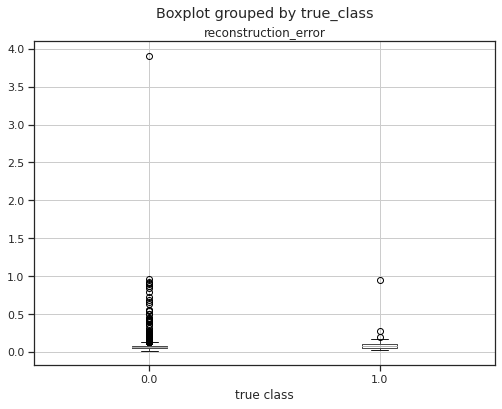

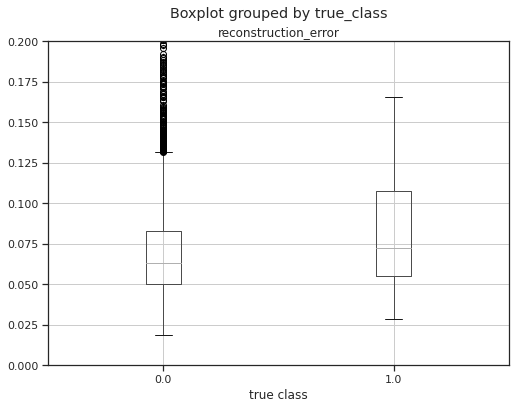

In [ ]:
error_vs_class_valid = rp.reconstructionerror_vs_class(model=sparse_autoencoder, 
                                                       sample=df_valid_x_rescaled, 
                                                       y=df_valid['y'])
plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid)
fig.savefig('sparse-autoencoder-model-master-boxplot.pdf', bbox_inches='tight')
plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid, ylim=[0., 0.2])
fig.savefig('sparse-autoencoder-model-snapshot-boxplot.pdf', bbox_inches='tight')

In [ ]:
errors_valid0 = rp.class_errors(error_vs_class=error_vs_class_valid, label = 0)
errors_valid1 = rp.class_errors(error_vs_class=error_vs_class_valid, label = 1)
rp.robust_stat_difference(z1=errors_valid0, z2=errors_valid1)

1.611673047555918

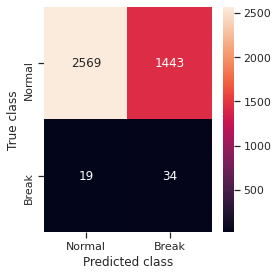

In [ ]:
error_vs_class_test = rp.reconstructionerror_vs_class(model=sparse_autoencoder, sample=df_test_x_rescaled, y=df_test['y'])
conf_matrix, fig = rp.model_confusion_matrix(error_vs_class=error_vs_class_test, 
                                          threshold=errors_valid1.quantile(0.50))
fig.savefig('sparse-autoencoder-model-conf-matrix.pdf', bbox_inches='tight')

# Classifier on Sparse Encodings: Autoencoder with feed forward classifier

In [ ]:
import utilities.performancemetrics as pm
df_train_x = df_train.drop(['y'], axis=1)
df_train_y = df_train['y'].values

df_train_x_rescaled = scaler.transform(df_train_x)

df_valid_y = df_valid['y'].values
df_test_y = df_test['y'].values

In [ ]:
encoder_model = Model(inputs=sparse_autoencoder.inputs, 
                      outputs=sparse_autoencoder.get_layer('encoder').output)
X_train_encoded_features = encoder_model.predict(df_train_x_rescaled)
X_valid_encoded_features = encoder_model.predict(df_valid_x_rescaled)
X_test_encoded_features = encoder_model.predict(df_test_x_rescaled)

In [ ]:
classifier = Sequential()
classifier.add(Input(shape=(X_train_encoded_features.shape[1], )))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 
                     tf.keras.metrics.Recall(),
                     pm.F1Score(),
                     pm.FalsePositiveRate()]
           )

history = classifier.fit(x=X_train_encoded_features,
                    y=df_train_y,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_encoded_features, df_valid_y),
                    verbose=0).history

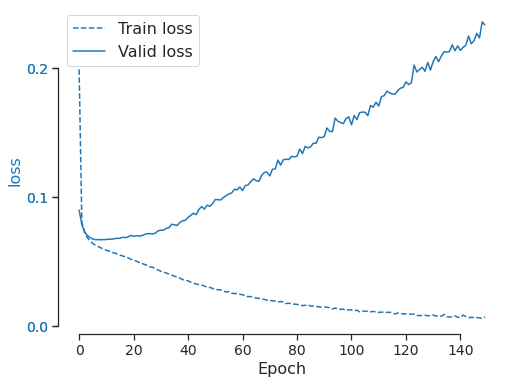

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('mlp_classifier_autoencoder_baseline_loss.pdf', bbox_inches='tight')

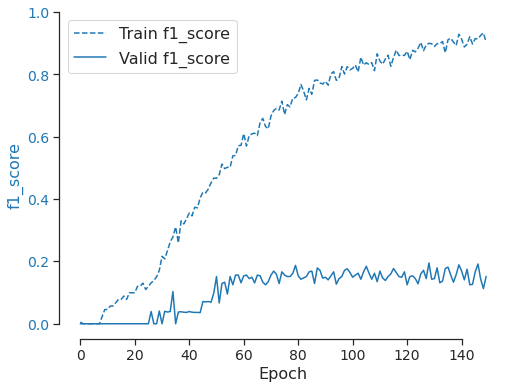

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('mlp_classifier_autoencoder_baseline_f1_score.pdf', bbox_inches='tight')

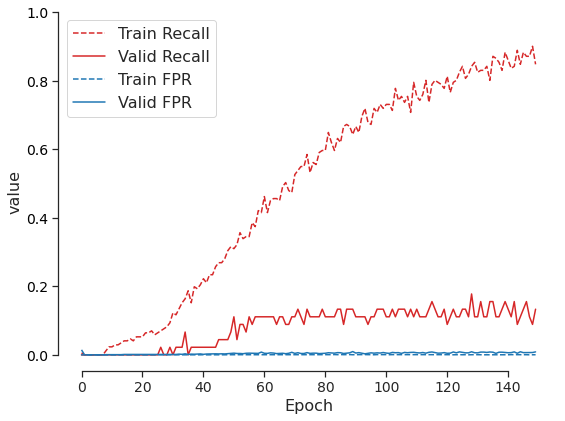

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('mlp_classifier_autoencoder_baseline_recall_fpr.pdf', bbox_inches='tight')

In [ ]:
y_test_hat = classifier.predict(x=X_test_encoded_features)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

In [ ]:
confusion_matrix(y_true=df_test_y, y_pred=np.round(y_test_hat))

array([[3986,   26],
       [  47,    6]])